# Project Experiments

In this notebook, we will be presenting the code for the experiments that have been done in the project. These experiments are namely:

- Check test predictions for trained model
- Generate predictions for ImageNet test dataset
- Conduct ablation study for model with 2 different architectures

These experiments have mostly been done on Ada via scripts, but have been compiled here in this notebook as proof of work. All the generated results have been uploaded to the OneDrive link shared, and the code present here is equivalent to the code used in the notebooks.

The python script train.py was run on Ada to train the models and generate checkpoints.

### Sample colourization output

In this section, we will take a random subset of images and attempt to output their colourization.

In [7]:
# import libraries
import os
import random
import tqdm
import cv2 as cv
import keras.backend as K
import numpy as np
import sklearn.neighbors as nn
import matplotlib.pyplot as plt
from Python_Scripts.model import build_base_model, build_ablation_model1, build_ablation_model2

In [8]:
# define parameters

img_rows, img_cols = 256, 256
nb_neighbors = 5
T = 0.38
epsilon = 1e-8

In [9]:
def load_image(filename):
    bgr = cv.imread(filename)
    gray = cv.imread(filename, 0)
    return cv.resize(bgr, (img_rows, img_cols), cv.INTER_CUBIC), cv.resize(gray, (img_rows, img_cols), cv.INTER_CUBIC)

def predict_image(lab, modelOption = 0):
    q_ab = []
    with open('Helper_Data/colour_spaces.txt', 'r') as f:
        for line in f:
            # read line and split on whitespace
            q_ab.append([int(x) for x in line.split()])
    q_ab = np.array(q_ab)
    nb_q = q_ab.shape[0]
    nn_finder = nn.NearestNeighbors(n_neighbors=nb_neighbors, algorithm='ball_tree').fit(q_ab)

    L, a, b = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]
    x_test = np.empty((1, img_rows, img_cols, 1), dtype=np.float32)
    x_test[0, :, :, 0] = L / 255.

    model = None    
    if modelOption == 0:
        # Base Model
        model = build_base_model()
        model.load_weights('Model_Checkpoints/base_model.hdf5')
    if modelOption == 1:
        # Ablation Model 1
        model = build_ablation_model1()
        model.load_weights('Model_Checkpoints/ablation_test1.hdf5')

    if modelOption == 2:
        # Ablation Model 2
        model = build_ablation_model2()
        model.load_weights('Model_Checkpoints/ablation_test2.hdf5')

    X_colorized = model.predict(x_test).reshape((img_rows // 4 * img_cols // 4, nb_q))

    X_colorized = np.exp(np.log(X_colorized + epsilon) / T)
    X_colorized = X_colorized / np.sum(X_colorized, 1)[:, np.newaxis]
    q_a, q_b = q_ab[:, 0].reshape((1, 313)), q_ab[:, 1].reshape((1, 313))
    X_a, X_b = np.sum(X_colorized * q_a, 1).reshape((img_rows // 4, img_cols // 4)), np.sum(X_colorized * q_b, 1).reshape((img_rows // 4, img_cols // 4))
    X_a, X_b = cv.resize(X_a, (img_rows, img_cols), cv.INTER_CUBIC) + 128, cv.resize(X_b, (img_rows, img_cols), cv.INTER_CUBIC) + 128
    return np.dstack((L, X_a, X_b)).astype(np.int32)


Output for Sample 1


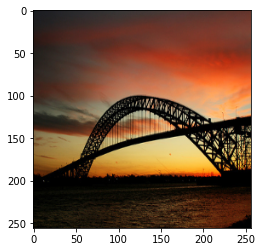

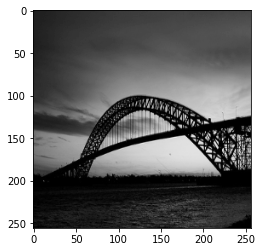

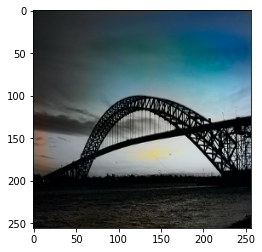


Output for Sample 2


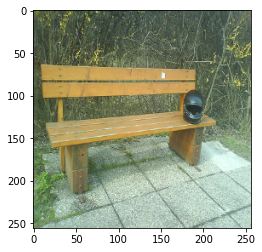

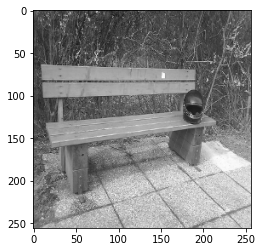

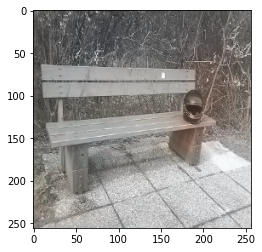


Output for Sample 3


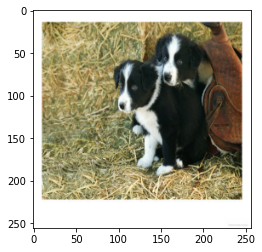

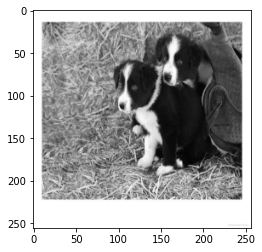

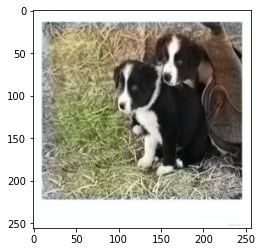


Output for Sample 4


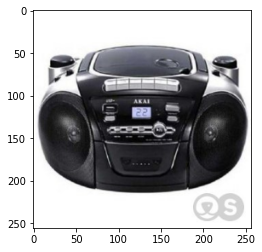

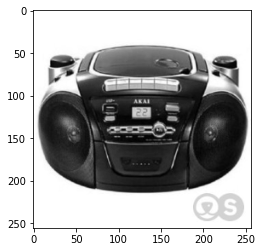

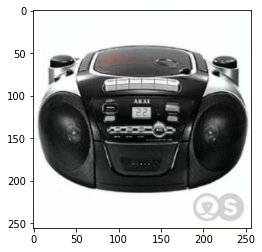


Output for Sample 5


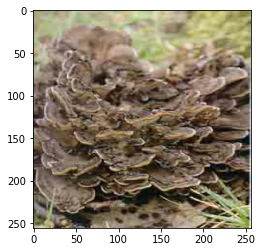

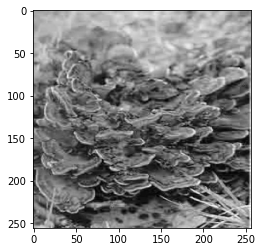

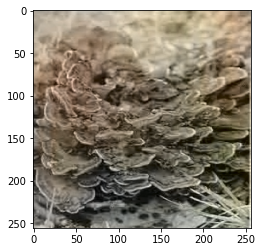

In [25]:
image_folder, names_file = '../Datasets/mini_imagenet/imagenet-mini/train_images', 'Helper_Data/val_filenames.txt'
names = [name.strip() for name in open(names_file)]
samples = [os.path.join(image_folder, name) for name in names]
samples = random.sample(samples, 5)

for i, sample in enumerate(samples):
    bgr, gray = load_image(sample)
    colorized = predict_image(cv.cvtColor(bgr, cv.COLOR_BGR2LAB))
    print(f"Output for Sample {i+1}")
    # print the original image, grey scale image and colorized image
    plt.imshow(cv.cvtColor(bgr, cv.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(gray, cmap='gray')
    plt.show()
    plt.imshow(cv.cvtColor(colorized.astype(np.uint8), cv.COLOR_LAB2RGB))
    plt.show()
    print("")

Now that the demo is done, we run the simulation for the entire validation folder of imageNet, and save the ground truth and predictions. As with train.py, this was run via a script on Ada, and the following is a representation of the code.

In [ ]:
image_folder = '../Datasets/mini_imagenet/imagenet-mini/val'
# get the names of the images in the folder, storing them in a list with the class folder name
names = []
for folder in os.listdir(image_folder):
    for file in os.listdir(os.path.join(image_folder, folder)):
        names.append(folder + '/' + file)

gt_dir = '../Datasets/mini_imagenet/imagenet-mini/test_images_gt_yee'
pred_dir = '../Datasets/mini_imagenet/imagenet-mini/test_images_pred_yee'


for i in tqdm.tqdm(range(len(names))):
    image_name = names[i]
    filename = os.path.join(image_folder, image_name)
    classname = image_name.split('/')[0]
    if not os.path.exists(os.path.join(gt_dir, classname)):
        os.makedirs(os.path.join(gt_dir, classname))
    if not os.path.exists(os.path.join(pred_dir, classname)):
        os.makedirs(os.path.join(pred_dir, classname))
        
    bgr, gray = load_image(sample)
    colorized = predict_image(cv.cvtColor(bgr, cv.COLOR_BGR2LAB))
    
    cv.imwrite(os.path.join(gt_dir, image_name), cv.cvtColor(bgr, cv.COLOR_BGR2RGB))
    cv.imwrite(os.path.join(gt_dir, image_name), cv.cvtColor(colorized.astype(np.uint8), cv.COLOR_LAB2RGB))

### Ablation Study

As seen, we see that there are two parallel ablation studies done for the model, wherein we have removed or updated certain model blocks to study the variance in performinace. For this, the function predict_model() has the option to rotate between either of the base, ablation study 1, and ablation study 2 models, allowing us to contrast the results for all.

In [4]:
basemodel = build_base_model()
basemodel.load_weights('Model_Checkpoints/base_model.hdf5')
print(basemodel.summary())

Model: "ColorNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                          

In [5]:
abl1model = build_ablation_model1()
abl1model.load_weights('Model_Checkpoints/ablation_test1.hdf5')
print(abl1model.summary())

Model: "ColorNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 conv2d_23 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 128)       147584    
                                                          

In [6]:
abl2model = build_ablation_model2()
abl2model.load_weights('Model_Checkpoints/ablation_test2.hdf5')
print(abl2model.summary())

Model: "ColorNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_35 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 conv2d_36 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_13 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 128)       147584    
                                                          

In [ ]:
image_folder, names_file = '../Datasets/mini_imagenet/imagenet-mini/train_images', 'Helper_Data/val_filenames.txt'
names = [name.strip() for name in open(names_file)]
samples = [os.path.join(image_folder, name) for name in names]
samples = random.sample(samples, 5)

for i, sample in enumerate(samples):
    bgr, gray = load_image(sample)
    colorized_base = predict_image(cv.cvtColor(bgr, cv.COLOR_BGR2LAB), 0)
    colorized_ablation1 = predict_image(cv.cvtColor(bgr, cv.COLOR_BGR2LAB), 1)
    colorized_ablation2 = predict_image(cv.cvtColor(bgr, cv.COLOR_BGR2LAB), 2)
    print(f"Output for Sample {i+1}")
    # print the original image, grey scale image and colorized image
    plt.imshow(cv.cvtColor(bgr, cv.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(gray, cmap='gray')
    plt.show()
    print("Base Model")
    plt.imshow(cv.cvtColor(colorized.astype(np.uint8), cv.COLOR_LAB2RGB))
    plt.show()
    print("Ablation Model 1")
    plt.imshow(cv.cvtColor(colorized_ablation1.astype(np.uint8), cv.COLOR_LAB2RGB))
    plt.show()
    print("Ablation Model 2")
    plt.imshow(cv.cvtColor(colorized_ablation2.astype(np.uint8), cv.COLOR_LAB2RGB))
    plt.show()
    print("")

The results of the ablation study have all been uploaded to the OneDrive link, provided in the README.md file